# WhatsApp Chat History Data Visualization

*Disclaimer: This is a work-in-progress notebook for prototyping my chat log data visualization tool. Code here may not be perfectly refactored / vectorized / optimized and therefore has plenty of scope for improvement!*

## Instructions

1. Ensure your WhatsApp-exported `chat.txt` file is in the top level directory.
2. (Optional) Modify the `Chat-History-User-Defined` notebook to include any custom slang words / variants for the script to consider.
3. Run all cells in this `Chat-History-Prototyping` notebook.
4. Run all cells the `Chat-History-Report` notebook.
5. A standalone HTML report titled "Chat-History-Report" will be created in the top level directory.

## Libraries and Modules

Let's start off by importing the libraries and modules used throughout the notebook:

#### Bread-and-Butter Data and Visualization Libraries:

In [374]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### General Utility Libraries:

In [375]:
import os.path
import string
from collections import defaultdict

#### Libraries for Processing Non-Text Data:

In [376]:
import datetime as dt
import emoji
from pytz import timezone
from dateutil.relativedelta import relativedelta

#### Libraries for Processing Text Data (incl. NLP Libraries):

In [377]:
import regex

# NLTK for all our languarge processing needs
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import words
from nltk.corpus import stopwords 

# If needed:
# nltk.download()

#### Matplotlib-Based Plotting / Utility Libraries:

In [378]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid.parasite_axes import SubplotHost
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox, AnchoredText)

We will also import the custom dictionaries defined in `Chat-History-Custom-Functs.ipynb`, which will be used in the text normalization process. Feel free to edit the dictionaries based on the desired 'slang normalization' for your corpus (scroll down to the **'Preprocessing Text Data'** section for more details).

In [379]:
%run Chat-History-User-Defined.ipynb

## Data Extraction

We'll read in the WhatsApp chat log (exported from an iOS device) to a dataframe and make a deepcopy for us to try out all of our preprocessing on. <br>
**Note:** For privacy purposes, the example chat log available on GitHub is much shorter and consists of dummy text, albeit maintaining WhatsApp's iOS app export style.

In [380]:
# Read in Whatsapp chat log to a dataframe
imported_messages = pd.read_csv('chat.txt', delimiter='\n', skiprows=[0], names = ['text_raw'])
imported_messages.head()

,text_raw
0,"[2018-12-21, 2:55:51 AM] User 1: From outside ..."
1,"[2018-12-21, 2:56:06 AM] User 2: and lool lool..."
2,"[2018-12-21, 2:56:08 AM] User 2: \ which told ..."
3,"[2018-12-21, 2:56:26 AM] User 2: hah lmaoooo w..."
4,"[2018-12-21, 2:56:40 AM] User 1: 😯 Far away we..."


In [381]:
imported_messages.tail()

,text_raw
395,"[2019-01-05, 6:09:43 AM] User 1: lool but the ..."
396,and still we sat waiting silently for whatever...
397,"[2019-01-05, 6:14:26 AM] User 1: I could, howe..."
398,"[2019-01-05, 6:16:21 AM] User 1: https://towar..."
399,"[2019-01-05, 6:16:25 AM] User 1: ‎Messages to ..."


**Note:** Using '\n' as the delimiter results in messages with embedded line breaks escaping to new rows in the dataframe. These rows will not have the '*\[datetime\] username: text*' pattern seen in other rows, so we need to handle these appropriately when separating out datetimes and usernames.

In [382]:
# Deepcopy into a working dataframe for preprocessing / cleaning
messages = imported_messages.copy(deep=True)
messages.iloc[7:11]

,text_raw
7,"[2018-12-21, 3:00:22 AM] User 1: ☺ Twelve struck,"
8,"and one and two and three,"
9,and still we sat waiting silently for whatever...
10,"‎[2018-12-21, 3:08:29 AM] User 1: ‎video omitted"


## Preprocessing Non-Text Data

Now let's work on extracting the datetime and username fields by leveraging [regular expressions](https://jakevdp.github.io/WhirlwindTourOfPython/14-strings-and-regular-expressions.html). We'll define a helper function to aid us with extracting usernames and datetimes, then apply it to our dataframe. Here is further reading on [Regex Match Objects](https://docs.python.org/2.0/lib/match-objects.html) and [Python string splitting](https://docs.python.org/3/library/stdtypes.html#str.split).

In [383]:
# Function to extract datetime and username as text
def extract_datetime_username(text):
    """
    Note:   Requires regex module to be imported
    Input:  String of text which may contain '[...]' text pattern
            Eg: "[2018-12-21, 2:55:51 AM] User 1: Messages to this chat and calls are now secured with end-to-end encryption."
            
    Output: Tuple of EITHER: (String to the right of the ': ' text pattern      Eg. "Messages to this chat and calls are now secured with end-to-end encryption."
                              String with contents of the '[...]' text pattern  Eg. "2018-12-21, 2:55:51 AM", 
                              String between the '[...]' and ': ' text patterns Eg. "User 1" )
                              
                     OR:     (String of of the original text if ''[...]'' pattern is not found,
                              NaN,
                              NaN)
    """
    # Regex to find '[...]' pattern in text. date_time is a Regex Match Object
    date_time = regex.search(r'.*\[(.*)\].*', text)
    
    # Output based on pattern search result
    if date_time:
        # Since we want to split only on the first occurrence of "] " and ": " respectively, we pass in maxsplit=1 on str.split()
        text_no_date = text.split("] ", maxsplit=1)[1]
        text_split_on_user = text_no_date.split(": ", maxsplit=1)
        return (text_split_on_user[1], date_time.group(1), text_split_on_user[0])
    else:
        return (text, np.nan, np.nan)

In [384]:
# Apply the function to our dataframe and extract out the datetimes and usernames
messages['text_raw'], messages['date_time'], messages['username'] = zip(*messages['text_raw'].apply(extract_datetime_username))
messages.head()

,text_raw,date_time,username
0,From outside came the occasional cry of a nigh...,"2018-12-21, 2:55:51 AM",User 1
1,and lool lool lool lool once at our very windo...,"2018-12-21, 2:56:06 AM",User 2
2,\ which told us that the cheetah was indeed at...,"2018-12-21, 2:56:08 AM",User 2
3,hah lmaoooo wooowww,"2018-12-21, 2:56:26 AM",User 2
4,😯 Far away we could hear the deep tones of the...,"2018-12-21, 2:56:40 AM",User 1


In [385]:
# Check to ensure functionality is as intended on rows with embedded line breaks
messages.iloc[7:11]

,text_raw,date_time,username
7,"☺ Twelve struck,","2018-12-21, 3:00:22 AM",User 1
8,"and one and two and three,",NaN,NaN
9,and still we sat waiting silently for whatever...,NaN,NaN
10,‎video omitted,"2018-12-21, 3:08:29 AM",User 1


Before we proceed, let's verify if there are any rows of text with none / NaN values.

In [386]:
messages[messages['text_raw'].isna()]

,text_raw,date_time,username


Now we can fill in the NaN values in the 'date_time' and 'username' columns by considering those messages to have been sent by the user in the row above, at the same time as the row above.

In [387]:
messages.fillna(method='ffill', inplace=True)
messages.iloc[7:11]

,text_raw,date_time,username
7,"☺ Twelve struck,","2018-12-21, 3:00:22 AM",User 1
8,"and one and two and three,","2018-12-21, 3:00:22 AM",User 1
9,and still we sat waiting silently for whatever...,"2018-12-21, 3:00:22 AM",User 1
10,‎video omitted,"2018-12-21, 3:08:29 AM",User 1


Let's leverage Python's `datetime` module to convert our date_time column from a string to handy datetime objects (which are localized in my case to Toronto, Canada). <br>

In [388]:
LOCAL_TIMEZONE = timezone('America/Toronto')

In [389]:
messages['date_time'] = pd.to_datetime(messages['date_time'], format='%Y-%m-%d, %I:%M:%S %p', errors='coerce').dt.tz_localize(LOCAL_TIMEZONE)
messages.head()

,text_raw,date_time,username
0,From outside came the occasional cry of a nigh...,2018-12-21 02:55:51-05:00,User 1
1,and lool lool lool lool once at our very windo...,2018-12-21 02:56:06-05:00,User 2
2,\ which told us that the cheetah was indeed at...,2018-12-21 02:56:08-05:00,User 2
3,hah lmaoooo wooowww,2018-12-21 02:56:26-05:00,User 2
4,😯 Far away we could hear the deep tones of the...,2018-12-21 02:56:40-05:00,User 1


Let's verify if there are any failed datetime conversions before we proceed.

In [390]:
messages[messages['date_time'].isnull()]

,text_raw,date_time,username


## Preprocessing Text Data

Now we're ready to work directly on the text data and make it more palatable for extracting insights from. For reference, let's outline what our [text preprocessing](https://www.kdnuggets.com/2019/04/text-preprocessing-nlp-machine-learning.html) pipeline will look like.

### Pipeline:
1. Tokenize each message
2. Separate out emojis (**Note:** This might be revisited if I begin investigating sentiment analysis)                    
3. Categorize each message type (text / image / video / link)
4. Clean text messages
5. Normalize user-specific slang in text messages
6. Remove stopwords from text messages

In [391]:
# Python String Library
#import string

# NLTK for all our languarge processing needs (tokenization and stopword removal - lemmatization if our data ends up too 'muddy')
#import nltk
##from nltk.tokenize import RegexpTokenizer
#from nltk.tokenize import TweetTokenizer
#from nltk.corpus import stopwords 
##from nltk.stem import WordNetLemmatizer 
##from normalise import normalise

In [392]:
# If needed:
# nltk.download()

### Step 1: Tokenization
Let's [tokenize](https://www.geeksforgeeks.org/tokenize-text-using-nltk-python/) our corpus of text messages! In this case, we'll use NLTK's `TweetTokenizer`, since it is capable of splitting up emoji groupings and identifying html links as single tokens (see [here](https://towardsdatascience.com/an-introduction-to-tweettokenizer-for-processing-tweets-9879389f8fe7) for a brief comparison between NLTK tokenizers).

In [393]:
tokenizer = TweetTokenizer()
messages['text_processed'] = messages['text_raw'].apply(lambda x: tokenizer.tokenize(x))
messages.tail()

,text_raw,date_time,username,text_processed
395,lool but the sudden glare lool lool flashing i...,2019-01-05 06:09:43-05:00,User 1,"[lool, but, the, sudden, glare, lool, lool, fl..."
396,and still we sat waiting silently for whatever...,2019-01-05 06:09:43-05:00,User 1,"[and, still, we, sat, waiting, silently, for, ..."
397,"I could, however, see that his face was deadly...",2019-01-05 06:14:26-05:00,User 1,"[I, could, ,, however, ,, see, that, his, face..."
398,https://towardsdatascience.com/an-introduction...,2019-01-05 06:16:21-05:00,User 1,[https://towardsdatascience.com/an-introductio...
399,‎Messages to this chat and calls are now secur...,2019-01-05 06:16:25-05:00,User 1,"[‎, Messages, to, this, chat, and, calls, are,..."


### Step 2: Emoji Extraction
Let's now extract out the emojis from the text - through a helper function defined below. This will simplify the workload involved in extracting out emoji-related insights in our visualizations down the line. <br><br>
**Note:** I had originally modified a solution found [here](https://stackoverflow.com/questions/49113909/split-and-count-emojis-and-words-in-a-given-string-in-python?noredirect=1&lq=1) to create a (very un-optimized!) solution that extracted emojis directly from the un-tokenized messages. However, this was before I discovered the magic of `TweetTokenizer`!
[This site](https://www.regular-expressions.info/) and [this post](https://stackoverflow.com/questions/9928505/what-does-the-expression-x-match-when-inside-a-regex)  provided a lot of insight into understanding and using regex (despite it not being needed as heavily).

In [394]:
# Function for separating out emojis from the tokenized corpus
def extract_emojis(tokenlist):
    """
    Input:  List of tokenized strings (utf-8), containing emojis 
    Output: Tuple of the following: (list of non-emoji tokens from the input, list of all emoji tokens from the input)
    """
    
    list_emojis = []
    list_text = []
    
    list_emojis = [token for token in tokenlist if any(char in emoji.UNICODE_EMOJI for char in token)]
    list_text = [token for token in tokenlist if token not in list_emojis]
    
    return (list_text, list_emojis)

#   **For reference, here's the original emoji list creation code without the one-liner list comprehensions
#    list_emojis = []
#    for token in tokenlist:
#        if any(char in emoji.UNICODE_EMOJI for char in token):  
#            list_emojis += [token]

In [395]:
# Apply it to our dataframe and extract out the emojis
messages['text_processed'], messages['emojis'] = zip(*messages['text_processed'].apply(extract_emojis))
messages.tail(10)

,text_raw,date_time,username,text_processed,emojis
390,😯👀,2019-01-05 06:02:52-05:00,User 1,[],"[😯, 👀]"
391,"""You see it, Watson?"" he yelled. ""You see it?""",2019-01-05 06:03:58-05:00,User 1,"["", You, see, it, ,, Watson, ?, "", he, yelled,...",[]
392,But I saw nothing lmaoo. 😯,2019-01-05 06:04:19-05:00,User 2,"[But, I, saw, nothing, lmaoo, .]",[😯]
393,‎image omitted,2019-01-05 06:04:19-05:00,User 2,"[‎, image, omitted]",[]
394,At the moment when Holmes struck the light I h...,2019-01-05 06:09:04-05:00,User 2,"[At, the, moment, when, Holmes, struck, the, l...",[]
395,lool but the sudden glare lool lool flashing i...,2019-01-05 06:09:43-05:00,User 1,"[lool, but, the, sudden, glare, lool, lool, fl...",[]
396,and still we sat waiting silently for whatever...,2019-01-05 06:09:43-05:00,User 1,"[and, still, we, sat, waiting, silently, for, ...",[]
397,"I could, however, see that his face was deadly...",2019-01-05 06:14:26-05:00,User 1,"[I, could, ,, however, ,, see, that, his, face...","[😭, 😭, 😭]"
398,https://towardsdatascience.com/an-introduction...,2019-01-05 06:16:21-05:00,User 1,[https://towardsdatascience.com/an-introductio...,[]
399,‎Messages to this chat and calls are now secur...,2019-01-05 06:16:25-05:00,User 1,"[‎, Messages, to, this, chat, and, calls, are,...",[]


### Step 3: Message Type Categorization
Since the WhatsApp chat log is text-only, any image or video media is represented as a message with the text *'image omitted'* or *'video omitted'* in it. In addition, shared links are sent as an individual message with the *'https://'* prefix and categorized into a single token by `TweetTokenizer`. We can use this information to categorize message types, as well as emptying the respective '*text_processed*' field for images and videos (since they aren't 'real' text messages).<br>
**Note:** The 'image omitted' and 'text omitted' text has a non-printable unicode typesetting character ([\u200e](https://www.fileformat.info/info/unicode/char/200e/index.htm)), hence the reason it is tokenized into 3 tokens, rather than the expected 2. Hidden / nonstandard characters such as this will be cleaned out in the next step.

In [396]:
messages['text_raw'].iloc[10][0]

'\u200e'

In [397]:
# Function for categorizing messages into types (Warning, I don't think function is very pythonic...)
def categorize_message(tokenlist):
    """
    Input:  Tokenized text string - i.e. list of words
    Output: Tuple of the following: (String indicating type of message - 'image', 'video', 'link' or 'text'),
                                     appropriate output token for the message type)
    """
    
    # Identify links based on prefix
    if (len(tokenlist) == 1):
        if (tokenlist[0][:8] == 'https://'):
            return ('link', tokenlist)
    
    # Identify images / video by default WhatsApp message ("\u200e image omitted" or "\u200e video omitted")
    elif len(tokenlist) == 3:
        if (tokenlist[2] == 'omitted'):
            
            if (tokenlist[1] == 'image'):
                return ('image', [])
            
            elif (tokenlist[1] == 'video'):
                return ('video', [])
    
    # Default is text
    return ('text', tokenlist)

In [398]:
# Apply function to dataframe
messages['msg_type'], messages['text_processed'] = zip(*messages['text_processed'].apply(categorize_message))
messages.head()

,text_raw,date_time,username,text_processed,emojis,msg_type
0,From outside came the occasional cry of a nigh...,2018-12-21 02:55:51-05:00,User 1,"[From, outside, came, the, occasional, cry, of...",[],text
1,and lool lool lool lool once at our very windo...,2018-12-21 02:56:06-05:00,User 2,"[and, lool, lool, lool, lool, once, at, our, v...","[😯, 😯, 😯]",text
2,\ which told us that the cheetah was indeed at...,2018-12-21 02:56:08-05:00,User 2,"[\, which, told, us, that, the, cheetah, was, ...",[],text
3,hah lmaoooo wooowww,2018-12-21 02:56:26-05:00,User 2,"[hah, lmaoooo, wooowww]",[],text
4,😯 Far away we could hear the deep tones of the...,2018-12-21 02:56:40-05:00,User 1,"[Far, away, we, could, hear, the, deep, tones,...","[😯, ☺]",text


In [399]:
print(messages['msg_type'].iloc[10], messages['text_raw'].iloc[10])

video ‎video omitted


In [400]:
messages.tail()

,text_raw,date_time,username,text_processed,emojis,msg_type
395,lool but the sudden glare lool lool flashing i...,2019-01-05 06:09:43-05:00,User 1,"[lool, but, the, sudden, glare, lool, lool, fl...",[],text
396,and still we sat waiting silently for whatever...,2019-01-05 06:09:43-05:00,User 1,"[and, still, we, sat, waiting, silently, for, ...",[],text
397,"I could, however, see that his face was deadly...",2019-01-05 06:14:26-05:00,User 1,"[I, could, ,, however, ,, see, that, his, face...","[😭, 😭, 😭]",text
398,https://towardsdatascience.com/an-introduction...,2019-01-05 06:16:21-05:00,User 1,[https://towardsdatascience.com/an-introductio...,[],link
399,‎Messages to this chat and calls are now secur...,2019-01-05 06:16:25-05:00,User 1,"[‎, Messages, to, this, chat, and, calls, are,...",[],text


### Step 4: Text Cleaning
Let's clean up the text by lowercasing all text, stripping leading / trailing whitespace, removing 'non-printable' characters (such punctuation and hidden characters such as '\u200e' which may be embedded in our text messages). <br>
**Note:** this may have the side effect of removing non-ascii characters, therefore might cause unintended behaviour if the message corpus contains **non-Latin ("English")** characters. 

In [401]:
# Define function for cleaning up text (lowercasing all text + stripping whitespace + removing non-alphanumeric characters)
def clean_text(tokenlist):
    tokenlist_clean = []
    
    for token_raw in tokenlist:
        token = token_raw.strip().lower()
        token_clean = "".join(c for c in token if str.isalnum(c))
        
        if len(token_clean) > 0:
            tokenlist_clean.append(token)
            
    return tokenlist_clean

In [402]:
# Apply it to our dataframe, skipping any 'link' messages to preserve the html formatting, but cleaning the other message types
messages['text_processed'] = np.where(messages['msg_type'] != 'link',
                                      messages['text_processed'].apply(clean_text),
                                      messages['text_processed'])

messages.tail()

,text_raw,date_time,username,text_processed,emojis,msg_type
395,lool but the sudden glare lool lool flashing i...,2019-01-05 06:09:43-05:00,User 1,"[lool, but, the, sudden, glare, lool, lool, fl...",[],text
396,and still we sat waiting silently for whatever...,2019-01-05 06:09:43-05:00,User 1,"[and, still, we, sat, waiting, silently, for, ...",[],text
397,"I could, however, see that his face was deadly...",2019-01-05 06:14:26-05:00,User 1,"[i, could, however, see, that, his, face, was,...","[😭, 😭, 😭]",text
398,https://towardsdatascience.com/an-introduction...,2019-01-05 06:16:21-05:00,User 1,[https://towardsdatascience.com/an-introductio...,[],link
399,‎Messages to this chat and calls are now secur...,2019-01-05 06:16:25-05:00,User 1,"[messages, to, this, chat, and, calls, are, no...",[],text


In [403]:
print(messages['text_processed'].iloc[-1])

['messages', 'to', 'this', 'chat', 'and', 'calls', 'are', 'now', 'secured', 'with', 'end-to-end', 'encryption']


### Step 5: Normalization (of User-Specific Slang)
Next, let's normalize our corpus of messages to manage any slang and slang variants. The initial implementation attempted to use the `normalize` library found [here](https://github.com/EFord36/normalise), but processing runtime was infeasible for this dataset. As an alternative, I defined my own custom normalizer to handle a user's 'chat-specific' slang. The normalizer primarily corrects slang words with repeated characters, as outlined in the comments below. The user can also define their own slang dictionary mappings in the auxiliary `Chat-History-User-Defined.ipynb` notebook. <br><br>
**Note**: `TweetTokenizer` has a `reduce_len` parameter which accomplishes a similar functionality ([see here](https://www.nltk.org/api/nltk.tokenize.html) for details), but it treats words under the '3 repeated characters' limit as unique words, and is not user-customizable *AFAIK*.

In [404]:
# Rough outline for custom normalizer:

# 1) Define sets of 'slang' strings based on type of expected non-normalization, for example:
# --- end-letter repeats (omgggg -> omg)
# --- combination repeats (wooowww -> wow)
# --- mid-letter repeats (looool -> lol)         [implemented via separate 'custom' dict instead]
# --- two-letter repeats (hahahaha -> haha)      [implemented via separate 'custom' dict instead]
# 2) Generate dicts which map slang variant to its 'root' form.
# --- Will be specific for each set and have an 'upper bound' number of repeats
# 3) Combine to a master 'normalization' dict. Define the custom normalization function to parse through the dict and evaluate feasibility of scaling up

# Expected runtime O(n*m) where n = number of tokens in corpus, m = number of keys in master normalization lookup dict
# Will be slow, but potentially m will at least 1-2 orders of magnitude smaller than using `normalise` library

# Custom / User defined:
# --- 'base' slang words and their 'type'
# --- 'upper bound' on number of repeats for dict generation

In [405]:
# Utility function to generate dicts of slang strings based on their type
def generate_slang_variants(SLANG_DICT, LIMIT = 5):
    """
    Input:    LIMIT:            Integer defining maximum number of repeated letters.
                                Default is 5 (i.e, 5 repeated single / double letters in the variant)
              SLANG_DICT:       Dictionary of string: integer pairs.
                                Strings are slang 'base' words. Integers are the slang variant 'type'defined below:
                                1 == Repeating single final letter (eg. lmaooooo -> lmao)
                                2 == Repeating double final letters (eg. wooooowwwww -> wow)
                                
    Output:   slang_lookup:     Dictionary of slang-variant : slang-root pairs
    """
    slang_lookup = {}
    
    for root in SLANG_DICT: #root[-2:]
                
        if SLANG_DICT[root] == 1:
            # Case 1: Repeat the single final letter up to limit. Add to final dictionary with root as value
            for i in range(LIMIT):
                variant = root + (root[-1]*i)
                slang_lookup.update({variant : root})
            
        elif SLANG_DICT[root] == 2:
            # Case 2: Generate combinations of both final letters up to limit. Add to final dictionary with root as value
            for i in range(1, LIMIT+1):
                for j in range(1, LIMIT+1):
                    variant = root[:-2] + (root[-2]*i) + (root[-1]*j)
                    slang_lookup.update({variant : root})
    
    return slang_lookup


In [406]:
# Primary function to normalize slang variants to their 'base' slang form
def normalize_slang(tokenlist, slang_lookup):
    """
    Input:    tokenlist:               Tokenized corpus to be parsed and normalized
              slang_lookup:            Dictionary of slang-variant : slang-root pairs

    Output:   tokenlist_normalized:    Normalized, tokenized corpus
    """
    tokenlist_normalized = []
    
    for token in tokenlist:
        if token in slang_lookup:
            tokenlist_normalized.append(slang_lookup[token])
        else:
            tokenlist_normalized.append(token)
    
    return tokenlist_normalized


In [407]:
# Generate final dictionary mapping slang variants to their 'base' slang word.
slang_lookup = generate_slang_variants(SLANG_DICT, VARIANT_LIMIT)

# 'Custom' slang variants are added to this final dictionary as well
slang_lookup.update(SLANG_SPECIAL_CASES)

In [408]:
# Apply function to dataframe and normalize slang on non-link messages
messages['text_processed'] = np.where(messages['msg_type'] != 'link',
                                      messages['text_processed'].apply(lambda x: normalize_slang(x, slang_lookup)),
                                      messages['text_processed'])
messages.tail()

,text_raw,date_time,username,text_processed,emojis,msg_type
395,lool but the sudden glare lool lool flashing i...,2019-01-05 06:09:43-05:00,User 1,"[lool, but, the, sudden, glare, lool, lool, fl...",[],text
396,and still we sat waiting silently for whatever...,2019-01-05 06:09:43-05:00,User 1,"[and, still, we, sat, waiting, silently, for, ...",[],text
397,"I could, however, see that his face was deadly...",2019-01-05 06:14:26-05:00,User 1,"[i, could, however, see, that, his, face, was,...","[😭, 😭, 😭]",text
398,https://towardsdatascience.com/an-introduction...,2019-01-05 06:16:21-05:00,User 1,[https://towardsdatascience.com/an-introductio...,[],link
399,‎Messages to this chat and calls are now secur...,2019-01-05 06:16:25-05:00,User 1,"[messages, to, this, chat, and, calls, are, no...",[],text


### Step 6: Stopword Removal
Finally, let's remove common [stopwords](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/) from our tokenized and cleaned (non-link) messages. This will ensure our data isn't polluted by common-use words. The user can also define additional stopwords in the `Chat-History-User-Defined.ipynb` notebook.

In [409]:
# Define standard set of stopwords
stopwords_set = set(stopwords.words('english'))

# Add user-defined custom stopwords to set
stopwords_set = stopwords_set | STOPWORDS_EXTRA

# List comprehension helper function to remove stopwords
def remove_stopwords(tokenlist):
    return [word.lower() for word in tokenlist if word.lower() not in stopwords_set]

In [410]:
# Apply function to dataframe and remove stopwords on non-link messages
messages['text_processed'] = np.where(messages['msg_type'] != 'link',
                                      messages['text_processed'].apply(remove_stopwords),
                                      messages['text_processed'])
messages.head()

,text_raw,date_time,username,text_processed,emojis,msg_type
0,From outside came the occasional cry of a nigh...,2018-12-21 02:55:51-05:00,User 1,"[outside, came, occasional, cry, night-bird]",[],text
1,and lool lool lool lool once at our very windo...,2018-12-21 02:56:06-05:00,User 2,"[window, long, drawn, catlike, whine]","[😯, 😯, 😯]",text
2,\ which told us that the cheetah was indeed at...,2018-12-21 02:56:08-05:00,User 2,"[told, us, cheetah, indeed, liberty]",[],text
3,hah lmaoooo wooowww,2018-12-21 02:56:26-05:00,User 2,"[hahaha, lmao, wow]",[],text
4,😯 Far away we could hear the deep tones of the...,2018-12-21 02:56:40-05:00,User 1,"[far, away, could, hear, deep, tones, parish, ...","[😯, ☺]",text


In [411]:
messages.tail()

,text_raw,date_time,username,text_processed,emojis,msg_type
395,lool but the sudden glare lool lool flashing i...,2019-01-05 06:09:43-05:00,User 1,"[sudden, glare, flashing, weary, eyes]",[],text
396,and still we sat waiting silently for whatever...,2019-01-05 06:09:43-05:00,User 1,"[still, sat, waiting, silently, whatever, migh...",[],text
397,"I could, however, see that his face was deadly...",2019-01-05 06:14:26-05:00,User 1,"[could, however, see, face, deadly, pale, fill...","[😭, 😭, 😭]",text
398,https://towardsdatascience.com/an-introduction...,2019-01-05 06:16:21-05:00,User 1,[https://towardsdatascience.com/an-introductio...,[],link
399,‎Messages to this chat and calls are now secur...,2019-01-05 06:16:25-05:00,User 1,"[messages, chat, calls, secured, end-to-end, e...",[],text


In [412]:
print(messages['text_processed'].iloc[-1])

['messages', 'chat', 'calls', 'secured', 'end-to-end', 'encryption']


Now that we've reduced our text messages to their keywords, lets add a column counting the number of keywords per message (which can be a basic, analagous metric for message length or complexity). We can add a similar column for number of emojis. We can also add a column for number of characters in the raw text message. **Note:** This will include all the 'cleaned' characters such as punctuation and emojis.

In [413]:
messages['count_keywords'] = messages['text_processed'].apply(len)
messages['count_emojis'] = messages['emojis'].apply(len)
messages['count_raw_chars'] = messages['text_raw'].apply(len)
messages.head()

,text_raw,date_time,username,text_processed,emojis,msg_type,count_keywords,count_emojis,count_raw_chars
0,From outside came the occasional cry of a nigh...,2018-12-21 02:55:51-05:00,User 1,"[outside, came, occasional, cry, night-bird]",[],text,5,0,52
1,and lool lool lool lool once at our very windo...,2018-12-21 02:56:06-05:00,User 2,"[window, long, drawn, catlike, whine]","[😯, 😯, 😯]",text,5,3,78
2,\ which told us that the cheetah was indeed at...,2018-12-21 02:56:08-05:00,User 2,"[told, us, cheetah, indeed, liberty]",[],text,5,0,55
3,hah lmaoooo wooowww,2018-12-21 02:56:26-05:00,User 2,"[hahaha, lmao, wow]",[],text,3,0,19
4,😯 Far away we could hear the deep tones of the...,2018-12-21 02:56:40-05:00,User 1,"[far, away, could, hear, deep, tones, parish, ...","[😯, ☺]",text,8,2,61


## Data Analysis and Visualization

Now for the fun part! Let's make a list of potential data vizualizations, in the context of a *two-person* conversation. We can also keep track of which dataframes are used for each vizualization - and create new ones if needed (TBD if not yet investigated or implemented)!

| Data Visualization Section | Analysis / Visualization Description                         | Dataframe Used in Visualization |
|:--------------------------:|:------------------------------------------------------------:|:-------------------------------:|
| **1:** General Stats       | Total messages by type, per user                             | `msg_summary_types`             |
| **1:** General Stats       | Average message statistics, per user                         | `msg_summary_counts`            |
| **1:** General Stats       | Top 10 days with most messages sent                          | `vis_timeseries_10_day`         |
| **1:** General Stats       | Average number of messages per day, per user                 | `timeseries_day`                | 
| **1:** General Stats       | Message with most keywords / emojis, per user                | `messages`                      |
| **1:** General Stats       | Messages statistics by type, per user                        | `timeseries_day`                |
| **2:** Run Chart           | Day-by-day time series for number of messages sent, per user | `vis_timeseries_day`            |
| **2:** Run Chart           | 7-Day average time series for number of messages sent, per user | `vis_timeseries_day`         |
| **3:** Word Stats          | Most used words, per user                                    | `text_expanded_by_user`         |
| **3:** Word Stats          | Longest words used                                           | `text_expanded_by_user`         |
| **4:** Emoji Stats         | Most used emojis, per user                                   | `emoji_expanded_by_user`        |
| **5:** Weekday Stats       | Average messages per hour of day, by weekday                 | `vis_timeseries_hour`           |
| **5:** Weekday Stats       | Average messages per weekday, per user                       | `vis_timeseries_week`           |
| **6:** Miscellaneous       | Longest consecutive days without messages sent               | `timeseries_deltas`             |
| **6:** Miscellaneous       | Sentiment analysis                                           | TBD                             |

### Visualization 1: General Stats
Before plotting the visualizations, let's define some useful globals which will be used across multiple plots.

In [414]:
# Get all unique usernames
USERLIST = list(messages['username'].unique())

# Get all unique message types
TYPELIST = list(messages['msg_type'].unique())

# Define a color palette for our plots and visualizations
PALETTE_FULL = sns.color_palette("RdBu", 19)
PALETTE_PAIR = [PALETTE_FULL[16], PALETTE_FULL[3]]

# Folder containing images to be plotted
PNG_FOLDER = "png-for-report"

In [415]:
class VisHandler:
    '''
    Class which handles saving visualizations, storing their file paths, and accessing file paths
    
    Instructions:
        Instantiate a VisHandler object (feeding in the appropriate folder directory) before plotting any visualizations
        Call save_vis() on the object once a visualization has been created and ready to save
        Call get_file_paths() to return a list of the saved vis file paths
    '''
    
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_paths = []
        self.file_counter = 0
    
    
    def save_vis(self):
        file_name = "{:02d}-vis.png".format(self.file_counter)
        file_path_current = os.path.join(self.folder_path, file_name) 
    
        # Save visualization
        plt.savefig(file_path_current, bbox_inches='tight')

        # Store image path into the object and increment counter ahead of the next save
        self.file_paths.append(file_path_current)
        print("Visualization '{:02d}-vis.png' saved".format(self.file_counter))
        
        self.file_counter += 1
        
    
    def get_current_counter(self):
        print("Last visualization saved: '{:02d}-vis.png'".format(self.file_counter-1))
        print("Current counter value: {}".format(self.file_counter))
    
    
    def get_file_paths(self):
        return self.file_paths
        

In [416]:
# Instantiate a VisHandler object to be used for the rest of the notebook
vis_handler = VisHandler(PNG_FOLDER)

- Total messages sent by user and category can be easily pivoted out from the `messages` dataframe:

In [417]:
msg_summary_types = pd.pivot_table(messages,
                                  values='text_processed',
                                  index='username',
                                  columns='msg_type',
                                  aggfunc=len).fillna(0)
msg_summary_types

msg_type,image,link,text,video
username,,,,
User 1,4,3,199,5
User 2,2,4,181,2


We can display these stats in simple 'card' visuals, which are defined through the function below:

In [418]:
# Function for plotting list of text strings into card visual form:
def create_card_visual(output_text, figure_size=(12,2.75), fig_title=""):
    
    # Define plot style, palette and font scaling
    sns.set_style('whitegrid')
    sns.set_palette(PALETTE_PAIR)
    sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

    # Plot 1 x 2 subplot axes to specified figure size.
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figure_size)

    for user, ax, color in zip(USERLIST, axs, PALETTE_PAIR):

        # Create and format annotation boxes and plot text
        textbox = AnchoredText(output_text[user], loc=10, pad=1, borderpad=0)
        textbox.patch.set_linewidth(1.5)
        textbox.patch.set_facecolor(color)
        textbox.patch.set_alpha(0.25)
        ax.add_artist(textbox)

        # Set title and hide axes
        ax.set_title(user, y = 1-(figure_size[1]/15), fontsize="large")
        ax.axis('off')

    # Pad and add figure title
    fig.tight_layout(pad=1.25)
    fig.suptitle(fig_title, weight="bold")
    
    return ax
    

The output text for the card visual is formatted separately and plotted as follows:

Visualization '00-vis.png' saved


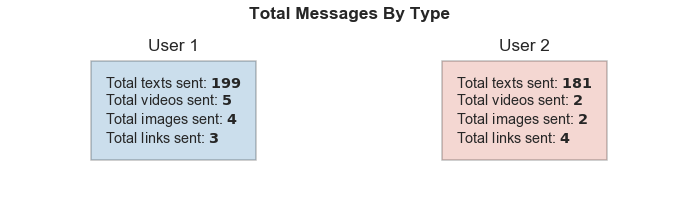

In [419]:
# Need to usse defaultdict to append list inside dictionary
output_text = defaultdict(list)

# Get stats from dataframe and appropriately format text string for card visual output
for user in USERLIST:
    for msg_type in TYPELIST:
        
        output_text[user].append("Total " + msg_type + "s sent: " +
                                 r"$\bf{" + "{}".format(msg_summary_types.loc[user][msg_type]) + "}$")
    
    # Concatenate into single string with line breaks
    output_text[user] = "\n".join(output_text[user])

    
# Plot card visual 
create_card_visual(output_text, (10,3), "Total Messages By Type")

# Save plot as png for reporting
vis_handler.save_vis()

#pngpath = os.path.join("png-for-report", "vis-0101-card-message-total.png")
#plt.savefig(pngpath, bbox_inches='tight')

#vis_paths.append(pngpath)
#fig_list.append(plt.gcf())

- Average number of keywords per text message, average number of characters per text message, and average number of emojis per message can be pivoted out from `messages`. They are then plotted using the same 'card' visual style.

In [420]:
msg_summary_counts = pd.pivot_table(messages[messages['msg_type']=='text'],
                                    values=['count_keywords', 'count_emojis', 'count_raw_chars'],
                                    index='username',
                                    aggfunc=np.mean).fillna(0)

msg_summary_counts

,count_emojis,count_keywords,count_raw_chars
username,,,
User 1,0.422111,11.597990,129.326633
User 2,0.441989,12.464088,144.104972


Visualization '01-vis.png' saved


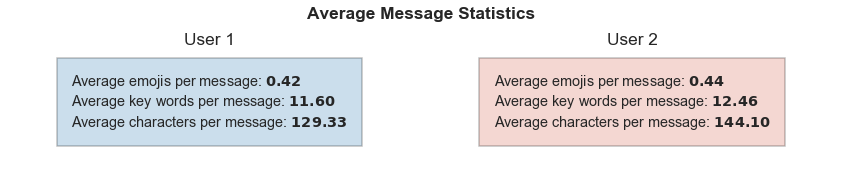

In [421]:
# Get stats from dataframe and appropriately format text string for card visual output
output_text = {}
for user in USERLIST:
    output_text[user] = ["Average emojis per message: " + r"$\bf{" + \
                         "{:.2f}".format(msg_summary_counts.loc[user]['count_emojis']) + "}$",
                         "Average key words per message: " + r"$\bf{" + \
                         "{:.2f}".format(msg_summary_counts.loc[user]['count_keywords']) + "}$",
                         "Average characters per message: " + r"$\bf{" + \
                         "{:.2f}".format(msg_summary_counts.loc[user]['count_raw_chars']) + "}$"]
    
    # Concatenate into single string with line breaks
    output_text[user] = "\n".join(output_text[user])
    
# Plot card visual 
create_card_visual(output_text, (12,2.75), "Average Message Statistics")

# Save plot as png for reporting
vis_handler.save_vis()

#pngpath = os.path.join("png-for-report", "vis-0102-card-message-averages.png")
#plt.savefig(pngpath, bbox_inches='tight')

#vis_paths.append(pngpath)
#fig_list.append(plt.gcf())

- To find the top 10 days with most messages sent, we can pivot `messages` to create a dataframe with records [grouped by day](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) and broken down by user and type.

In [422]:
# Pivot
timeseries = pd.pivot_table(messages,
                            values='text_processed',
                            index='date_time', 
                            columns=['username', 'msg_type'], 
                            aggfunc=len).fillna(0)
timeseries.head()

username                  User 1                 User 2                
msg_type                   image link text video  image link text video
date_time                                                              
2018-12-21 02:55:51-05:00    0.0  0.0  1.0   0.0    0.0  0.0  0.0   0.0
2018-12-21 02:56:06-05:00    0.0  0.0  0.0   0.0    0.0  0.0  1.0   0.0
2018-12-21 02:56:08-05:00    0.0  0.0  0.0   0.0    0.0  0.0  1.0   0.0
2018-12-21 02:56:26-05:00    0.0  0.0  0.0   0.0    0.0  0.0  1.0   0.0
2018-12-21 02:56:40-05:00    0.0  0.0  1.0   0.0    0.0  0.0  0.0   0.0

In [423]:
# Resample dataframe by day
timeseries_day = timeseries.resample('D').sum()

timeseries_day.head()

username                  User 1                  User 2                 
msg_type                   image link  text video  image link  text video
date_time                                                                
2018-12-21 00:00:00-05:00    3.0  1.0  67.0   3.0    0.0  2.0  61.0   1.0
2018-12-22 00:00:00-05:00    0.0  0.0   0.0   0.0    0.0  0.0   0.0   0.0
2018-12-23 00:00:00-05:00    0.0  0.0   0.0   0.0    0.0  0.0   0.0   0.0
2018-12-24 00:00:00-05:00    0.0  0.0   6.0   0.0    0.0  0.0   8.0   0.0
2018-12-25 00:00:00-05:00    0.0  0.0   0.0   0.0    0.0  0.0   0.0   0.0

We can create a similar dataframe to aggregate data by user and plot the 10 busiest days:

In [424]:
# Deepcopy into new dataframe used in plotting top 10 days
vis_timeseries_10_day = timeseries_day.copy(deep=True)

# Create total column, sort from most to least messages, drop total column
vis_timeseries_10_day['total'] = timeseries_day.sum(axis=1)
vis_timeseries_10_day.sort_values(by='total', ascending=False, inplace=True)
vis_timeseries_10_day.drop("total", axis=1, inplace=True)

# Slice out the top 10 days
vis_timeseries_10_day = vis_timeseries_10_day.iloc[:10]

# Aggregate per user, stack and reindex
vis_timeseries_10_day = vis_timeseries_10_day.sum(level=0, axis=1).reset_index()
vis_timeseries_10_day = vis_timeseries_10_day.melt(id_vars=['date_time'], var_name="username", value_name="msg_qty")

# Format date_time
vis_timeseries_10_day['date_time_formatted'] = vis_timeseries_10_day['date_time'].apply(lambda x: x.strftime("%d-%b-%y"))

vis_timeseries_10_day.head()

,date_time,username,msg_qty,date_time_formatted
0,2018-12-21 00:00:00-05:00,User 1,74.0,21-Dec-18
1,2019-01-01 00:00:00-05:00,User 1,44.0,01-Jan-19
2,2019-01-02 00:00:00-05:00,User 1,31.0,02-Jan-19
3,2019-01-04 00:00:00-05:00,User 1,21.0,04-Jan-19
4,2019-01-05 00:00:00-05:00,User 1,20.0,05-Jan-19


[This post](https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values) outlines an optional plotting function which allows bar plot values to be included (works on both horizontal and vertical bar plots).

In [425]:
# Optional plotting function to annotate barplot with bar values
def show_values_on_bars(axs, h_v="v", space=0.4):
    """
    Input:     axs:      Matplotlib axis object
               h_v:      Whether the barplot is horizontal or vertical. 
                         "h" represents the horizontal barplot, "v" represents the vertical barplot.
               space:    The space between value text and the top edge of the bar. Only works for horizontal mode.
               
    Output:    ax.text(): Annotates figure at the calculated x and y co-ordinates with the bar value
    """
    
    # Set this to shift the y-axis alignment of the bar value text
    align_factor = 0.6
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + float(space)
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center", fontsize="small") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() * align_factor
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="center", fontsize="small")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

Visualization '02-vis.png' saved


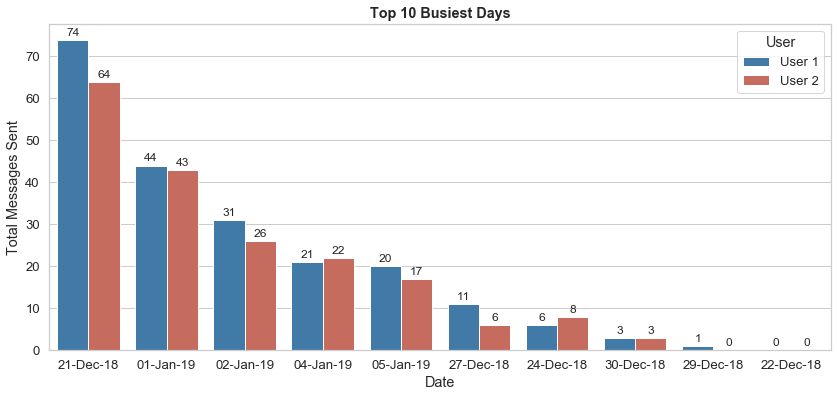

In [426]:
# Define plot style, palette and font scaling
sns.set_style('whitegrid')
sns.set_palette(PALETTE_PAIR)
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

# Plot grouped barplots
fig, ax = plt.subplots(figsize=(14, 6))
ax = sns.barplot(data=vis_timeseries_10_day, x='date_time_formatted', y="msg_qty", hue="username")

# Use custom function to add values on top of bars, with specified spacing
show_values_on_bars(ax, "v", 1)

# Formatting axes elements and titles
ax.set_title("Top 10 Busiest Days", weight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Total Messages Sent")
#handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(title="User", loc="upper right")

# Save plot as png for reporting
vis_handler.save_vis()


In [427]:
vis_handler.get_current_counter()

Last visualization saved: '02-vis.png'
Current counter value: 3


- Using the `timeseries_day` and `messages` dataframes, we can visualize a few more aggregate stats in 'card' form:

Visualization '03-vis.png' saved


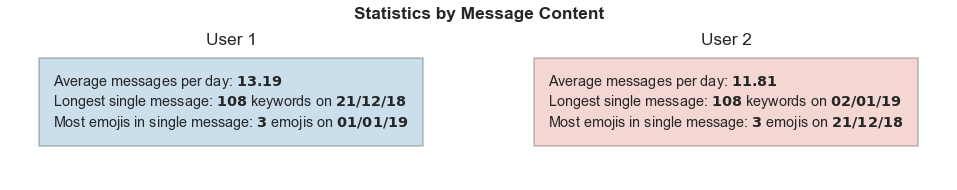

In [428]:
# Get stats from dataframe and appropriately format text string for card visual output
output_text = {}
for user in USERLIST:
    
    # Index of max values
    idx_message = messages[messages['username']==user]['count_keywords'].idxmax()
    idx_emoji = messages[messages['username']==user]['count_emojis'].idxmax()
    
    
    output_text[user] = ["Average messages per day: " +
                         r"$\bf{" + "{:.2f}".format(timeseries_day[user].sum(axis=1).mean()) + "}$",
                         
                         "Longest single message: " +
                         r"$\bf{" + "{}".format(messages['count_keywords'].iloc[idx_message]) + "}$ keywords on" +
                         r"$\bf{ \;" + "{}".format(messages['date_time'].iloc[idx_message].strftime("%d/%m/%y")) + "}$",
                         
                         "Most emojis in single message: " +
                         r"$\bf{" + "{}".format(messages['count_emojis'].iloc[idx_emoji]) + "}$ emojis on" +
                         r"$\bf{ \;" + "{}".format(messages['date_time'].iloc[idx_emoji].strftime("%d/%m/%y")) + "}$"]
    
    # Concatenate into single string with line breaks
    output_text[user] = "\n".join(output_text[user])

    
# Plot card visual 
create_card_visual(output_text, (14,2.75), "Statistics by Message Content")

# Save plot as png for reporting
vis_handler.save_vis()

#pngpath = os.path.join("png-for-report", "vis-0104-card-msg-content.png")
#plt.savefig(pngpath, bbox_inches='tight')

#vis_paths.append(pngpath)
#fig_list.append(plt.gcf())

Visualization '04-vis.png' saved


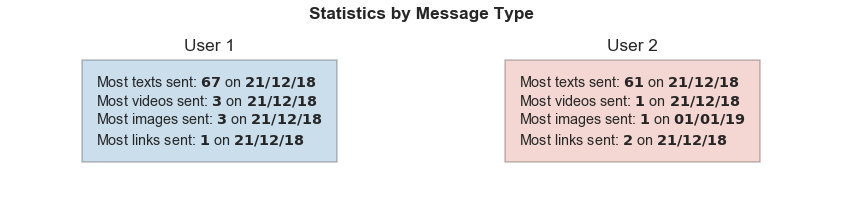

In [429]:
# Need to usse defaultdict to append list inside dictionary
output_text = defaultdict(list)

# Get stats from dataframe and appropriately format text string for card visual output
for user in USERLIST:
    for msg_type in TYPELIST:
        
        # Get max value and date it occurs on
        max_value = timeseries_day.xs((user, msg_type), axis=1).max()
        max_date = timeseries_day.xs((user, msg_type), axis=1).idxmax().strftime("%d/%m/%y")
        
        output_text[user].append("Most " + msg_type + "s " + "sent: " +
                                 r"$\bf{" + "{}".format(int(max_value)) + "}$ on" +
                                 r"$\bf{ \;" + "{}".format(max_date) + "}$")
    
    # Concatenate into single string with line breaks
    output_text[user] = "\n".join(output_text[user])

    
# Plot card visual 
create_card_visual(output_text, (12,3), "Statistics by Message Type")

# Save plot as png for reporting
vis_handler.save_vis()

#pngpath = os.path.join("png-for-report", "vis-0105-card-msg-type.png")
#plt.savefig(pngpath, bbox_inches='tight')

#vis_paths.append(pngpath)
#fig_list.append(plt.gcf())

### Visualization 2: Run Chart
The `timeseries_day` dataframe can be used to create a 'run chart' of day-by-day message counts, separated by user. Given the expected noisiness of the data if done over a long time frame, we can also plot a rolling averaged version. The vizualization is meant as a primarily birds-eye view of the data, as well as being able to highlight noteable time periods / events of interest.

In [430]:
# Create a new dataframe by aggregate all message types per user, stacking, and reindexing
vis_timeseries_day = timeseries_day.sum(level=0, axis=1).reset_index()
vis_timeseries_day = vis_timeseries_day.melt(id_vars=['date_time'], var_name="username", value_name="msg_qty")

vis_timeseries_day.head()

,date_time,username,msg_qty
0,2018-12-21 00:00:00-05:00,User 1,74.0
1,2018-12-22 00:00:00-05:00,User 1,0.0
2,2018-12-23 00:00:00-05:00,User 1,0.0
3,2018-12-24 00:00:00-05:00,User 1,6.0
4,2018-12-25 00:00:00-05:00,User 1,0.0


In [431]:
# Create 7-day rolling average, per user
rolling_by_user = vis_timeseries_day.groupby('username')['msg_qty'].rolling(7).mean().reset_index()

# Add rolling average column to vis_timeseries_day dataframe
vis_timeseries_day['msg_qty_rolling'] = rolling_by_user.set_index('level_1')['msg_qty']
vis_timeseries_day.tail(7)

,date_time,username,msg_qty,msg_qty_rolling
25,2018-12-30 00:00:00-05:00,User 2,3.0,2.428571
26,2018-12-31 00:00:00-05:00,User 2,0.0,1.285714
27,2019-01-01 00:00:00-05:00,User 2,43.0,7.428571
28,2019-01-02 00:00:00-05:00,User 2,26.0,11.142857
29,2019-01-03 00:00:00-05:00,User 2,0.0,10.285714
30,2019-01-04 00:00:00-05:00,User 2,22.0,13.428571
31,2019-01-05 00:00:00-05:00,User 2,17.0,15.857143


In [432]:
# Define the limits for the plot's x-axis
time_start = vis_timeseries_day.iloc[0]['date_time'].replace(day=1) - dt.timedelta(days=1)                             # Last day of previous month
time_end = vis_timeseries_day.iloc[-1]['date_time'].replace(day=1, month=vis_timeseries_day.iloc[-1]['date_time'].month+1) # First day of next month

In [433]:
# Helper function to define tick positions and tick labels for the additional 'year' axis included in the plot
def find_xaxis_params(axis, time_start, time_end):
    """
    Input:     axis:             Matplotlib axis object - the 'original' x-axis of the plot with ticks defined outside the function 
    
               time_start:       Starting datetime object of the x-axis plot. Defined as:
                                    - First chronological datetime from the vis_timeseries_day dataframe
                                    - Day set to 1st of that month
                                    - Moved back 1 day (i.e, last day of the previous month)
                                    
               time_end:         Ending datetime object of the x-axis plot. Defined as:
                                    - Last chronological datetime from the vis_timeseries_day dataframe
                                    - Day set to 1st of that month
                                    - Moved forward 1 month (i.e, first day of the next month)
    
    Output:    Tuple of the following:
               year_ticks:       List of relative positions (0 - 1) corresponding to each tick where a year begins
               year_labels:      List of strings with the name of the year
               year_label_ticks: List of relative positions (0 - 1) corresponding to the tick where the year label is drawn
    """
    
    # Define the relative positions (from 0 - 1) of each tick in the x-axis
    x_min, x_max = axis.get_xlim()
    ticks = [(tick - x_min)/(x_max - x_min) for tick in axis.get_xticks()]
    
    # Get datetime which matches the first displayed label on the x-axis
    time_start_label = time_start + dt.timedelta(days=1)
    
    # Get datetime which matches the last displayed label on the x-axis
    time_end_label = time_end
    
    
    # Define initial values for our outputs and helper variable 'year_ticks_index'
    year_ticks = [ticks[0]]
    year_ticks_index = [0]
    year_labels = [time_start_label.strftime("%Y")]
    year_label_ticks = []
    prev_label = time_start_label
    
    # Loop through each tick (skipping first)
    for idx, tick in enumerate(ticks[1:], start=1):
        curr_label = prev_label + relativedelta(months=1)

        # If the year has changed, store the value and index of that particular tick. Also capture the year name
        if (curr_label.year != prev_label.year):
            year_ticks.append(tick)
            year_ticks_index.append(idx)
            year_labels.append(curr_label.strftime("%Y"))

        prev_label = curr_label

        
    # Add the value and index of the last tick to their respective lists
    year_ticks.append(ticks[-1])
    year_ticks_index.append(len(ticks)-1)
    
    
    # Loop through each year-tick (ending before the last element since we are forward-windowing in this loop)
    for idx, tick in enumerate(year_ticks_index[:-1]):

        # Calculate the delta between the current year-tick and next year-tick
        delta = year_ticks_index[idx+1] - year_ticks_index[idx]
        i = year_ticks_index[idx] + int(delta // 2)
        j = i + 1
        
        # If delta is even, use middle tick between the year-ticks. Else average between the middle ticks.
        if (delta % 2 == 0):
            year_label_ticks.append(ticks[i])
        else:
            year_label_ticks.append((ticks[i]+ticks[j]) / 2)

    return (year_ticks, year_labels, year_label_ticks)


In [434]:
# Select colour palette for plotting
palette_RdBu = sns.color_palette("RdBu", 19)
PALETTE_PAIR = [palette_RdBu[16], palette_RdBu[3]]

Visualization '05-vis.png' saved


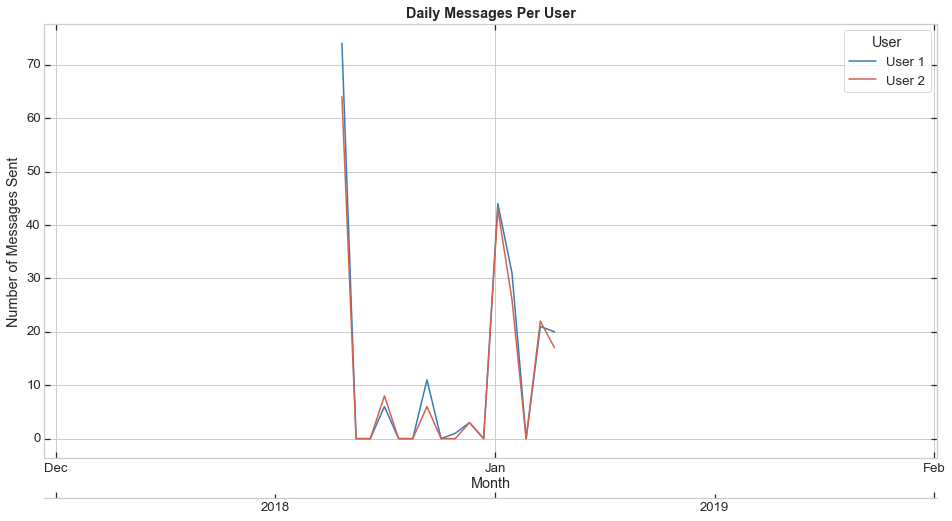

In [435]:
# Define plot style, palette and font scaling
sns.set_style('whitegrid')
sns.set_palette(PALETTE_PAIR)
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

# Set figure size, first (host) axes, and plot using Seaborn
fig = plt.figure(figsize=(16,8))
ax1 = SubplotHost(fig, 111)
fig.add_subplot(ax1)
ax1 = sns.lineplot(data=vis_timeseries_day, x="date_time", y="msg_qty", hue="username", ci=None)

# Define by-month ticks on x-axis, define formatting, and define limits
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax1.set_xlim(left=time_start, right=time_end)

# Use helper function to define tick parameters for the second 'parasite' axis
year_ticks, year_labels, year_label_ticks = find_xaxis_params(ax1, time_start, time_end)

# Create second axis, position, and modify visibility
ax2 = ax1.twiny()
offset = 0, -40    # Hardcoded position of the second axis
new_axisline = ax2.get_grid_helper().new_fixed_axis
ax2.axis["bottom"] = new_axisline(loc="bottom", axes=ax2, offset=offset)
ax2.axis["top"].set_visible(False)
ax1.axis["top"].set_visible(True)

# Define / draw second axis using params
ax2.set_xticks(year_ticks)
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator(year_label_ticks))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(year_labels))

# Formatting axes elements and titles
ax1.set_title("Daily Messages Per User", weight="bold")
ax1.set_xlabel("Month")
ax1.set_ylabel("Number of Messages Sent")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[1:], labels=labels[1:], title="User")

# Save plot as png for reporting
vis_handler.save_vis()

#pngpath = os.path.join("png-for-report", "vis-0201-lineplot-timeseries")
#plt.savefig(pngpath, bbox_inches='tight')

#vis_paths.append(pngpath)
#fig_list.append(plt.gcf())

Visualization '06-vis.png' saved


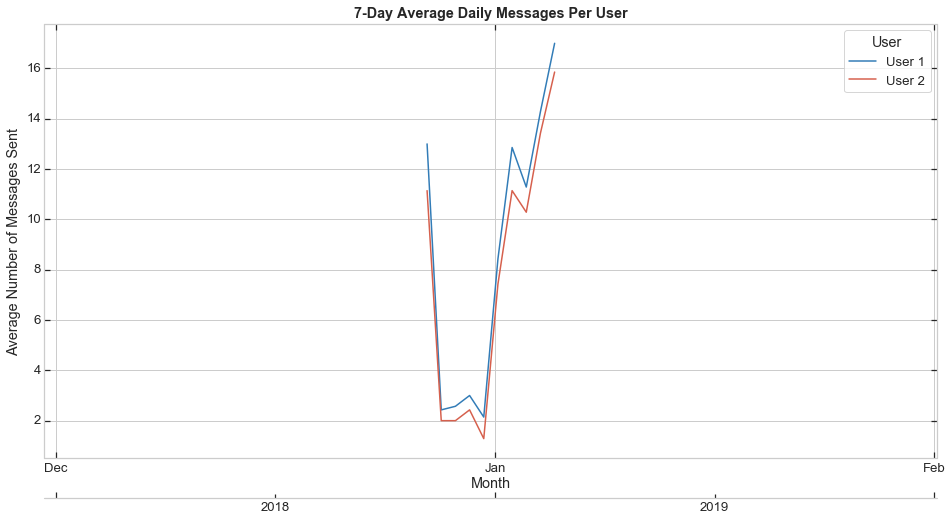

In [436]:
# Define plot style, palette and font scaling
sns.set_style('whitegrid')
sns.set_palette(PALETTE_PAIR)
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

# Set figure size, first (host) axes, and plot using Seaborn
fig = plt.figure(figsize=(16,8))
ax1 = SubplotHost(fig, 111)
fig.add_subplot(ax1)
ax1 = sns.lineplot(data=vis_timeseries_day, x="date_time", y="msg_qty_rolling", hue="username", ci=None)

# Define by-month ticks on x-axis, define formatting, and define limits
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax1.set_xlim(left=time_start, right=time_end)

# Use helper function to define tick parameters for the second 'parasite' axis
year_ticks, year_labels, year_label_ticks = find_xaxis_params(ax1, time_start, time_end)

# Create second axis, position, and modify visibility
ax2 = ax1.twiny()
offset = 0, -40    # Hardcoded position of the second axis
new_axisline = ax2.get_grid_helper().new_fixed_axis
ax2.axis["bottom"] = new_axisline(loc="bottom", axes=ax2, offset=offset)
ax2.axis["top"].set_visible(False)
ax1.axis["top"].set_visible(True)

# Define / draw second axis using params
ax2.set_xticks(year_ticks)
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator(year_label_ticks))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(year_labels))

# Formatting axes elements and titles
ax1.set_title("7-Day Average Daily Messages Per User", weight="bold")
ax1.set_xlabel("Month")
ax1.set_ylabel("Average Number of Messages Sent")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[1:], labels=labels[1:], title="User")

# Save plot as png for reporting
vis_handler.save_vis()

#pngpath = os.path.join("png-for-report", "vis-0202-lineplot-7day")
#plt.savefig(pngpath, bbox_inches='tight')

#vis_paths.append(pngpath)
#fig_list.append(plt.gcf())

### Visualization 3: Word Stats
- Creating visualizations on a 'per-word' bases requires us to have access to the individual tokens in `messages['text_processed']`. We can explode out each token to a new row and preserve usernames (in a new dataframe) as follows:

In [437]:
text_expanded = messages[['username','text_processed']].explode('text_processed').dropna()
text_expanded.head()

,username,text_processed
0,User 1,outside
0,User 1,came
0,User 1,occasional
0,User 1,cry
0,User 1,night-bird


We need to pivot this data such that we obtain rows for counts of each unique word, broken down per user. This can be done as follows:

In [438]:
# Pivot
text_expanded_by_user = text_expanded.pivot_table(text_expanded, 
                                                  index='text_processed', 
                                                  columns='username', 
                                                  aggfunc=len).fillna(0)

# Create and populate a 'total' column
text_expanded_by_user['total'] = text_expanded_by_user.sum(axis=1)

# Sort by most common words
text_expanded_by_user.sort_values(by='total', ascending=False, inplace=True)
        
# Re-index dataframe and fix column naming
text_expanded_by_user = text_expanded_by_user.reset_index()
text_expanded_by_user.rename_axis(None, axis=1, inplace=True)

text_expanded_by_user.head(15)

,text_processed,User 1,User 2,total
0,holmes,33.0,32.0,65.0
1,said,26.0,33.0,59.0
2,little,21.0,15.0,36.0
3,upon,18.0,17.0,35.0
4,lmao,14.0,16.0,30.0
5,one,10.0,20.0,30.0
6,mr,13.0,16.0,29.0
7,see,21.0,7.0,28.0
8,hahaha,14.0,14.0,28.0
9,would,18.0,10.0,28.0


A horizontal comparative barplot was used to visualize this data. [This post](https://stackoverflow.com/questions/27694221/using-python-libraries-to-plot-two-horizontal-bar-charts-sharing-same-y-axis) provides guidance on the methodology used to create the non-standard visualization below.

Visualization '07-vis.png' saved


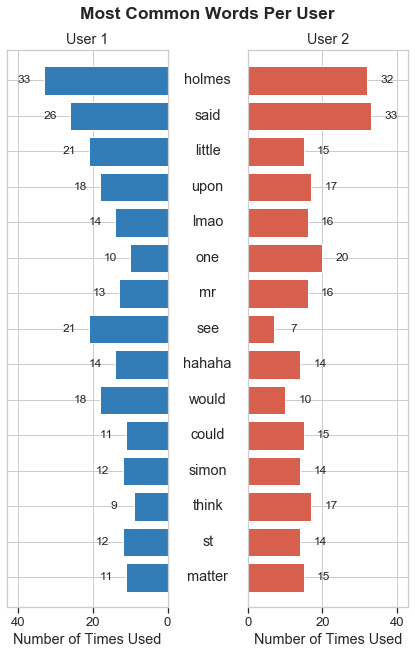

In [439]:
# Define plot style, palette and font scaling
sns.set_style('whitegrid')
sns.set_palette(PALETTE_PAIR)
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

# Select the number of words/emojis to be shown in the visualization
max_items = 15

# Extract relevant data from dataframe into lists
y_words = text_expanded_by_user.iloc[0:max_items]["text_processed"].tolist()
ax0_values = text_expanded_by_user.iloc[0:max_items, 1].tolist()
ax1_values = text_expanded_by_user.iloc[0:max_items, 2].tolist()
user_names = text_expanded_by_user.columns.values[1:3].tolist()

# Define values for y-axis ticks and define x-axis limit
y = np.arange(len(y_words))
max_itemcount = max(ax0_values + ax1_values) * 1.3


# Plot figure to specified size, with 2 sublpots sharing a common y-axis
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(6,10))
axes[0].barh(y_words, ax0_values, align='center', color=PALETTE_PAIR[0])
axes[0].set_title(user_names[0])
axes[0].set_xlim(0, max_itemcount)
axes[0].set_xlabel("Number of Times Used")
axes[0].tick_params(axis='x', which='major', bottom=True)

axes[1].barh(y_words, ax1_values, align='center', color=PALETTE_PAIR[1])
axes[1].set_title(user_names[1])
axes[1].set_xlim(0, max_itemcount)
axes[1].set_xlabel("Number of Times Used")
axes[1].tick_params(axis='x', which='major', bottom=True)

# Invert y-axis and left-side x-axis. Remove existing y-axis labels
axes[0].invert_yaxis()
axes[0].invert_xaxis()
axes[0].set(yticks=y_words, yticklabels=[])

# Add y-axis labels in desired location and text/emoji orientation
for yloc, label in zip(y, y_words):
    axes[0].annotate(label, (0.5, yloc), xycoords=('figure fraction', 'data'), ha='center', va='center')
    
# OPTIONAL: Add values to each bar using helper function
show_values_on_bars(axes, "h", max_itemcount/8)

# Add margins to top/bottom of graph
for ax in axes.flat:
    ax.margins(0.03)

# Add common figure title and adjust subplot positions as required    
fig.suptitle("Most Common Words Per User", weight="bold").set_y(0.91)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.subplots_adjust(wspace=0.5)

# Save plot as png for reporting
vis_handler.save_vis()

#pngpath = os.path.join("png-for-report", "vis-0301-barplot-words")
#plt.savefig(pngpath, bbox_inches='tight')

#vis_paths.append(pngpath)
#fig_list.append(plt.gcf())

- Finding the longest used word requires a bit of additional manipulation of the `text_expanded_by_user` dataset. The wordlist includes url text so we need to lookup each word in an English language dictionary (`words` from `nltk.corpus` in this case - it isn't the best wordlist but it probably isn't worth the effort to import a large library for the sake of a one-line visualization).

In [440]:
from nltk.corpus import words
wordset = set(words.words())

In [441]:
# Add a column to capture word lengths (will be used later)
text_expanded_by_user['word_len'] = text_expanded_by_user['text_processed'].apply(len)

# Add a column to determine word presence in English
text_expanded_by_user["english_word"] = text_expanded_by_user["text_processed"].apply(lambda x: x in wordset)

# Sort by word length and English-only words, and select longest word
text_expanded_by_user[text_expanded_by_user['english_word']].sort_values(by='word_len', ascending=False).head()

,text_processed,User 1,User 2,total,word_len,english_word
631,superscription,1.0,1.0,2.0,14,True
588,correspondence,3.0,0.0,3.0,14,True
554,individuality,0.0,3.0,3.0,13,True
195,extraordinary,4.0,2.0,6.0,13,True
395,unprecedented,2.0,2.0,4.0,13,True


### Visualization 4: Emoji Stats
We can repeat the process above to obtain a similar dataframe for emojis. **Note:** Need to'de-emojize' before pivoting, since many identical emojis were unnecessarily represented differently in unicode. To display as emojis in visualizations, must 're-emojize' the emojis.

In [442]:
emoji_expanded = messages[['username','emojis']].explode('emojis').dropna()
emoji_expanded.head()

,username,emojis
1,User 2,😯
1,User 2,😯
1,User 2,😯
4,User 1,😯
4,User 1,☺


In [443]:
# De-emoji in-progress dataframe
emoji_expanded['emojis'] = emoji_expanded['emojis'].apply(emoji.demojize)

# Pivot
emoji_expanded_by_user = emoji_expanded.pivot_table(emoji_expanded, 
                                                  index='emojis', 
                                                  columns='username', 
                                                  aggfunc=len).fillna(0)

# Create and populate a 'total' column
emoji_expanded_by_user['total'] = emoji_expanded_by_user.sum(axis=1)

# Sort by most common emojis
emoji_expanded_by_user.sort_values(by='total', ascending=False, inplace=True)

# Re-index dataframe and fix column naming
emoji_expanded_by_user = emoji_expanded_by_user.reset_index()
emoji_expanded_by_user.rename_axis(None, axis=1, inplace=True)

# 'Re-emoji' in a separate column
emoji_expanded_by_user['emojis_disp'] = emoji_expanded_by_user['emojis'].apply(emoji.emojize)

emoji_expanded_by_user.head(10)

,emojis,User 1,User 2,total,emojis_disp
0,:hushed_face:,39,32,71,😯
1,:loudly_crying_face:,15,30,45,😭
2,:eyes:,8,5,13,👀
3,:grinning_squinting_face:,7,4,11,😆
4,:smiling_face:,8,2,10,☺
5,:frowning_face:,3,4,7,☹
6,:grinning_face_with_smiling_eyes:,4,3,7,😄


The same horizontal barplot visualization used in **Vizualization 3** can be modified to display emoji usage statistics. This required additional work in order to implement emoji images as y-axis labels. [Twemoji](https://github.com/twitter/twemoji/tree/gh-pages) was used as an open-source image repository and [this link](https://matplotlib.org/examples/pylab_examples/demo_annotation_box.html) provides some guidance for annotating using images.
<br><br> 
**Note:** Matplotlib unfortunately scales PNG files horribly when drawing figures. To rectify this, I was able to leverage the [CairoSVG](https://cairosvg.org/documentation/) library to draw the Twemoji source SVGs into PNGs of an appropriate size, avoiding any matplotlib scaling. Unfortunately, the actual installation of CairoSVG was a bit complicated (it was installed as part of another library called [WeasyPrint](https://weasyprint.readthedocs.io/en/latest/install.html)), so I have chosen to do this SVG -> PNG conversion offline. I have provided the converted 24x24 pixel PNGs in the repo, as well as the `svg_to_png.py` script used to do the conversion if you wish to re-draw the images to a different size. However, this is fair warning that without re-drawing the images, *YMMV* when trying to editing dimensions of the visualization below.

In [444]:
# Function to populate filepaths for each emoji in dataframe to the Twemoji library
def utf8_to_filepath(emoji_utf8):
    """
    Input:     emoji_utf8: Emoji in UTF-8 encoding
    Output:    relative file path pointing from this notebook's current directory to the appropriate Twemoji .png file
    """
    folderpath = os.path.join("twemoji-gh-pages", "emojilib", "png")
    emoji_codepoint = str(hex(ord(emoji_utf8)))[2:]
    
    return os.path.join(folderpath, emoji_codepoint + ".png")


In [445]:
utf8_to_filepath(emoji_expanded_by_user['emojis_disp'].iloc[0])

'twemoji-gh-pages\\emojilib\\png\\1f62f.png'

In [446]:
# Apply the function to the emoji_expanded_by_user dataframe
emoji_expanded_by_user["img_path"] = emoji_expanded_by_user["emojis_disp"].apply(utf8_to_filepath)
emoji_expanded_by_user.head()

,emojis,User 1,User 2,total,emojis_disp,img_path
0,:hushed_face:,39,32,71,😯,twemoji-gh-pages\emojilib\png\1f62f.png
1,:loudly_crying_face:,15,30,45,😭,twemoji-gh-pages\emojilib\png\1f62d.png
2,:eyes:,8,5,13,👀,twemoji-gh-pages\emojilib\png\1f440.png
3,:grinning_squinting_face:,7,4,11,😆,twemoji-gh-pages\emojilib\png\1f606.png
4,:smiling_face:,8,2,10,☺,twemoji-gh-pages\emojilib\png\263a.png


In [447]:
# Matplotlib import for drawing images in annotations
#from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
#from matplotlib.cbook import get_sample_data

Visualization '08-vis.png' saved


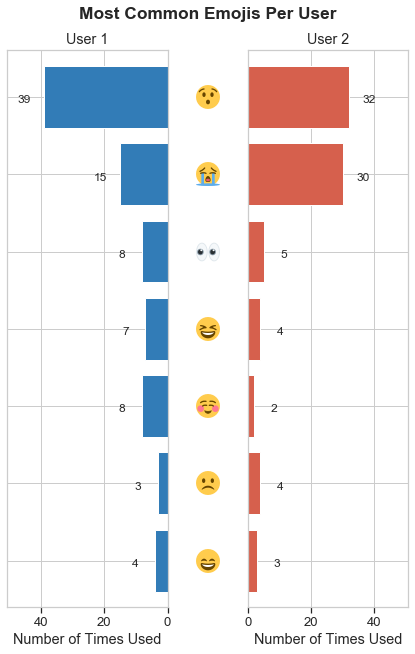

In [448]:
# Define plot style, palette and font scaling
sns.set_style('whitegrid')
sns.set_palette(PALETTE_PAIR)
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

# Select the number of words/emojis to be shown in the visualization
max_items = 15

# Extract relevant data from dataframe into lists
y_emojis = emoji_expanded_by_user.iloc[0:max_items]["img_path"].tolist()
ax0_values = emoji_expanded_by_user.iloc[0:max_items, 1].tolist()
ax1_values = emoji_expanded_by_user.iloc[0:max_items, 2].tolist()
user_names = emoji_expanded_by_user.columns.values[1:3].tolist()

# Define values for y-axis ticks and define x-axis limit
y = np.arange(len(y_emojis))
max_itemcount = max(ax0_values + ax1_values) * 1.3


# Plot figure to specified size, with 2 sublpots sharing a common y-axis
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(6,10))
axes[0].barh(y_emojis, ax0_values, align='center', color=PALETTE_PAIR[0])
axes[0].set_title(user_names[0])
axes[0].set_xlim(0, max_itemcount)
axes[0].set_xlabel("Number of Times Used")
axes[0].tick_params(axis='x', which='major', bottom=True)

axes[1].barh(y_emojis, ax1_values, align='center', color=PALETTE_PAIR[1])
axes[1].set_title(user_names[1])
axes[1].set_xlim(0, max_itemcount)
axes[1].set_xlabel("Number of Times Used")
axes[1].tick_params(axis='x', which='major', bottom=True)

# Invert y-axis and left-side x-axis. Remove existing y-axis labels
axes[0].invert_yaxis()
axes[0].invert_xaxis()
axes[0].set(yticks=y_emojis, yticklabels=[])


# Add y-axis labels in desired location and text/emoji orientation
for yloc, emoji_path in zip(y, y_emojis):
    
    # Read in current image
    arr_img = plt.imread(emoji_path, format='png')

    # Define image parameters and axes
    imagebox = OffsetImage(arr_img, zoom=1)
    imagebox.image.axes = ax

    # Define annotation parameters for drawing the image in the correct location (with ticks)
    ab = AnnotationBbox(imagebox, (0.5, yloc), 
                        xybox=(0, 0), 
                        xycoords=('figure fraction', 'data'), 
                        boxcoords="offset points", 
                        bboxprops=dict(edgecolor=None), 
                        pad=0.25)

    # Add the image annotation to the figure
    axes[0].add_artist(ab)
    
    
# OPTIONAL: Add values to each bar using helper function
show_values_on_bars(axes, "h", max_itemcount/8)

# Add margins to top/bottom of graph
for ax in axes.flat:
    ax.margins(0.03)

# Add common figure title and adjust subplot positions as required    
fig.suptitle("Most Common Emojis Per User", weight="bold").set_y(0.91)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.subplots_adjust(wspace=0.5)

# Save plot as png for reporting
vis_handler.save_vis()

#pngpath = os.path.join("png-for-report", "vis-0401-barplot-emojis")
#plt.savefig(pngpath, bbox_inches='tight')

#vis_paths.append(pngpath)
#fig_list.append(plt.gcf())

### Visualization 5: Weekday Stats
To get a day-of-the-week breakdown of messaging data, we'll need to adopt a similar resampling approach as the `timeseries_day` dataframe, but with a bit more creativity to give the hour-by-hour granularity desired.

In [449]:
# Pivot (without msg_type column)
timeseries_hour = pd.pivot_table(messages,
                                values='text_processed',
                                index='date_time', 
                                columns='username', 
                                aggfunc=len).fillna(0)
timeseries_hour.head()

username,User 1,User 2
date_time,,
2018-12-21 02:55:51-05:00,1.0,0.0
2018-12-21 02:56:06-05:00,0.0,1.0
2018-12-21 02:56:08-05:00,0.0,1.0
2018-12-21 02:56:26-05:00,0.0,1.0
2018-12-21 02:56:40-05:00,1.0,0.0


In [450]:
# Resample dataframe by hour, unstack and reindex
timeseries_hour = timeseries_hour.resample('H').sum()
timeseries_hour = timeseries_hour.unstack().rename("msg_qty").reset_index()
timeseries_hour.head()

,username,date_time,msg_qty
0,User 1,2018-12-21 02:00:00-05:00,2.0
1,User 1,2018-12-21 03:00:00-05:00,18.0
2,User 1,2018-12-21 04:00:00-05:00,24.0
3,User 1,2018-12-21 05:00:00-05:00,0.0
4,User 1,2018-12-21 06:00:00-05:00,0.0


In [451]:
# Extract weekday and hour from date_time
timeseries_hour['weekday'] = timeseries_hour['date_time'].apply(lambda x: x.strftime('%A'))
timeseries_hour['hour'] = timeseries_hour['date_time'].apply(lambda x: x.hour)
timeseries_hour.head()

,username,date_time,msg_qty,weekday,hour
0,User 1,2018-12-21 02:00:00-05:00,2.0,Friday,2
1,User 1,2018-12-21 03:00:00-05:00,18.0,Friday,3
2,User 1,2018-12-21 04:00:00-05:00,24.0,Friday,4
3,User 1,2018-12-21 05:00:00-05:00,0.0,Friday,5
4,User 1,2018-12-21 06:00:00-05:00,0.0,Friday,6


In [452]:
# Aggregate dataframe to get average messages by username-weekday-hour groups
timeseries_hour_agg = timeseries_hour.groupby(['username', 'weekday', 'hour']).agg({'msg_qty': 'mean'})
timeseries_hour_agg.head()

msg_qty
username weekday hour          
User 1   Friday  0     0.000000
                 1     0.000000
                 2     0.666667
                 3     6.000000
                 4     8.333333

 - To plot the total hourly average messages per weekday, we can first group the aggregated data accordingly. We can plot this aggregated data using [Polar Plots](https://matplotlib.org/gallery/pie_and_polar_charts/polar_bar.html#sphx-glr-gallery-pie-and-polar-charts-polar-bar-py) as a primarily comparative visualization - separated by weekday and broken down by hour. [This post](https://stackoverflow.com/questions/56418087/how-to-plot-time-stamps-hhmm-on-python-matplotlib-clock-polar-plot) provides guidance on implementing timeseries data and bar plots in polar form.

In [453]:
# Average number of messages sent on each weekday-hour, sum across both users, and reindex for plot-friendliness
vis_timeseries_hour = timeseries_hour_agg.sum(level=[1,2])
vis_timeseries_hour.reset_index(inplace=True)
vis_timeseries_hour.head()

,weekday,hour,msg_qty
0,Friday,0,0.000000
1,Friday,1,0.000000
2,Friday,2,2.000000
3,Friday,3,9.333333
4,Friday,4,15.000000


In [454]:
# Convert hour to radians for use in plotting
vis_timeseries_hour['rad'] = vis_timeseries_hour['hour'] * 2 * np.pi / 24
vis_timeseries_hour.head()

,weekday,hour,msg_qty,rad
0,Friday,0,0.000000,0.000000
1,Friday,1,0.000000,0.261799
2,Friday,2,2.000000,0.523599
3,Friday,3,9.333333,0.785398
4,Friday,4,15.000000,1.047198


Visualization '09-vis.png' saved


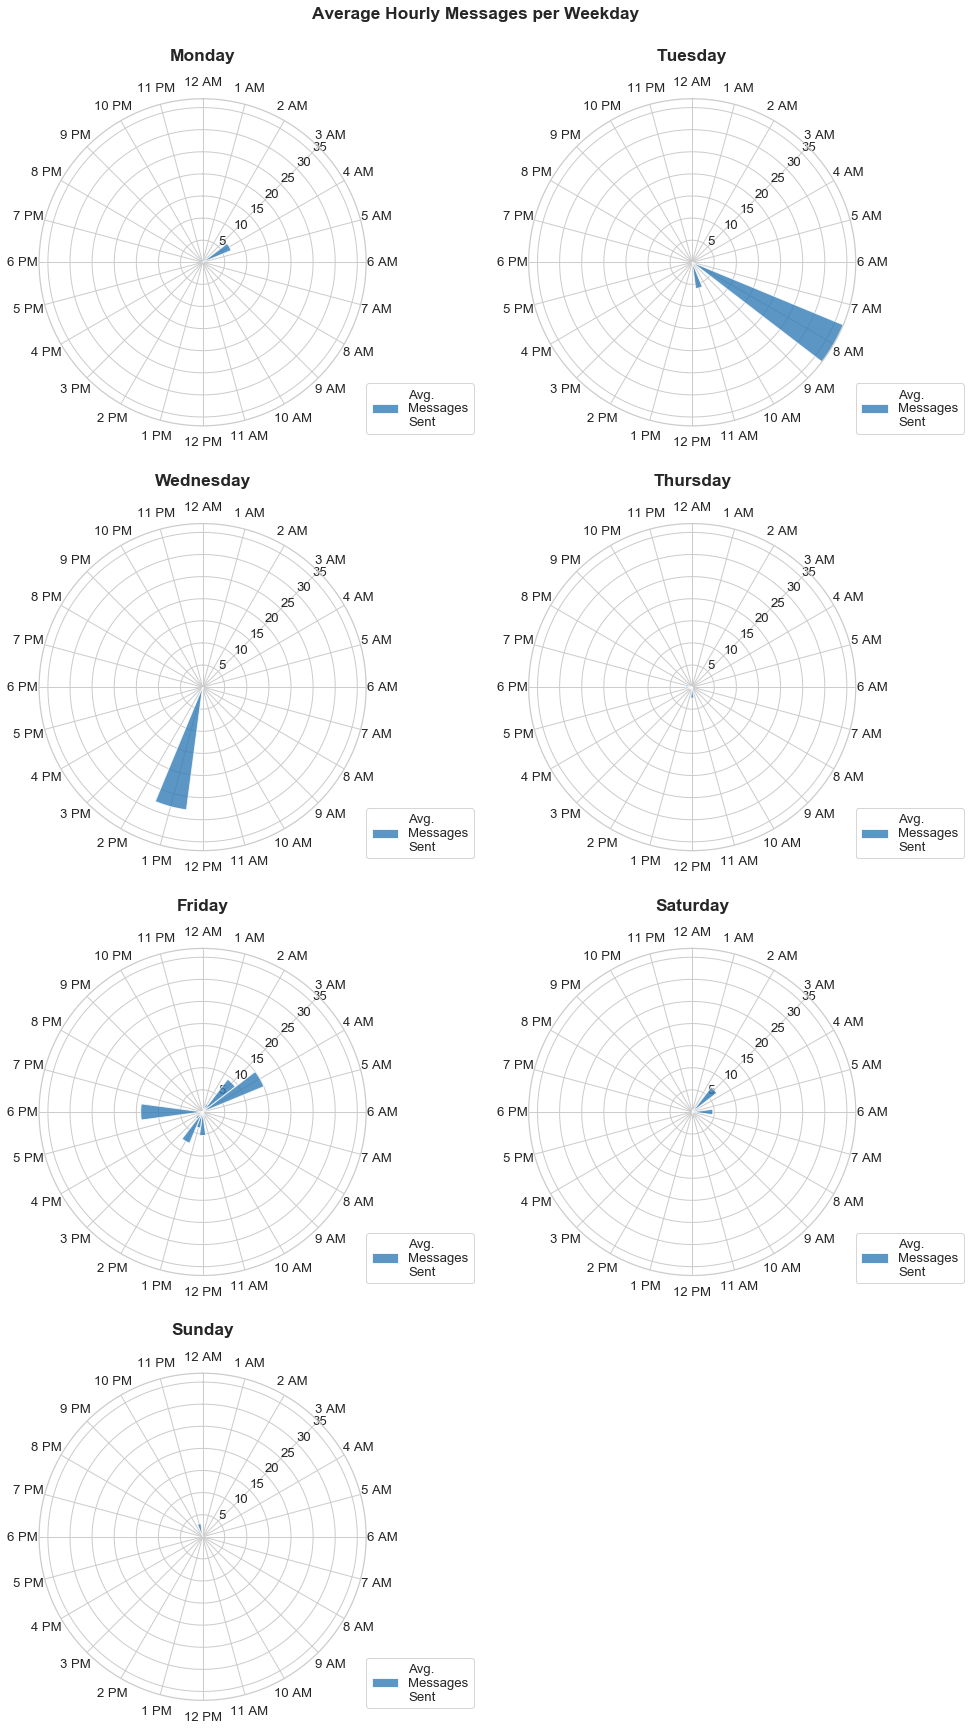

In [455]:
# Define plot style, palette and font scaling
sns.set_style('whitegrid')
sns.set_palette(PALETTE_PAIR)
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

# Alias the dataframe used for plotting
ts = vis_timeseries_hour
ts_max = ts['msg_qty'].max()

# Specify number of rows and columns for the plot 
ncol = 2
nrow = 4

# Plot axes to specified figure size. Delete extra subplot.
# NOTE: Subplot code operates under the assumption that 7 unique weekdays will be plotted
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, subplot_kw=dict(projection='polar'), figsize=(14,24))
fig.delaxes(axs.flat[-1])

# Define text labels for filtering and plotting
label_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
label_ticks = ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM', 
               '12 PM', '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM' ]

# Define bar width
cust_width = 2*np.pi / len(label_ticks)

# Iterate through days and axis objects simultaneously
for day, ax in zip(label_days, axs.flat[:-1]):

    # Filter out data to be plotted
    data_r = ts[ts['weekday']==day]['msg_qty']
    data_theta = ts[ts['weekday']==day]['rad']
    
    # Reset indices
    data_r.reset_index(drop=True, inplace=True)
    data_theta.reset_index(drop=True, inplace=True)
    
    # Plot bars
    ax.bar(data_theta, data_r, width = cust_width, alpha=0.8, label=day)

    # Ensure the labels go clockwise
    ax.set_theta_direction(-1)

    # Align '12 AM' to the 'North' of the plot
    ax.set_theta_offset(np.pi/2)

    # Set the circumference ticks
    ax.set_xticks(np.linspace(0, 2*np.pi, len(label_ticks), endpoint=False))

    # Set the label names
    ax.set_xticklabels(label_ticks)
    
    # Set range limit to max value of dataframe
    ax.set_rlim(0, ts_max)
    
    # Align range axis to '3 AM' (typically least populated)
    ax.set_rlabel_position(np.rad2deg(cust_width*3))
    
    # Set subplot title and spacing
    ax.set_title(day, y = 1.1, fontsize="large", weight="bold")
    
    # Set legend
    ax.legend(["Avg.\nMessages\nSent"], bbox_to_anchor=(1.35, 0.15))
    
    
# Set padding between subplots and add fig title
fig.tight_layout(pad=2)
fig.suptitle("Average Hourly Messages per Weekday", y=1.01, weight="bold")


# Save plot as png for reporting
vis_handler.save_vis()

#pngpath = os.path.join("png-for-report", "vis-0501-radial-hourly")
#plt.savefig(pngpath, bbox_inches='tight')

#vis_paths.append(pngpath)
#fig_list.append(plt.gcf())

 - The `timeseries_hour_agg` dataframe can also be leveraged to show the weekday average message frequency per user. A simple bar plot can be used to visualize this data.

In [456]:
# Aggregate to get number of messages sent on each weekday, per user
# Then set index to only weekday, slice in chronological order, then reset
vis_timeseries_week = timeseries_hour_agg.sum(level=[0,1]).reset_index().set_index('weekday').loc[label_days].reset_index()
vis_timeseries_week.head()

,weekday,username,msg_qty
0,Monday,User 1,3.0
1,Monday,User 2,4.0
2,Tuesday,User 1,22.0
3,Tuesday,User 2,21.5
4,Wednesday,User 1,15.5


Visualization '10-vis.png' saved


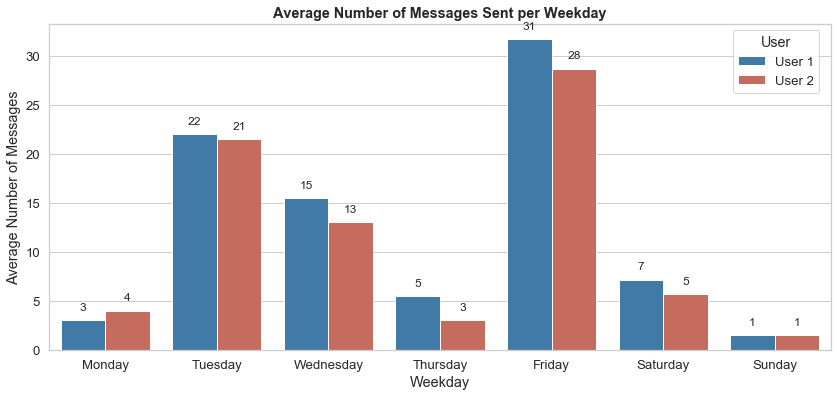

In [457]:
# Define plot style, palette and font scaling
sns.set_style('whitegrid')
sns.set_palette(PALETTE_PAIR)
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

# Plot grouped barplots
fig, ax = plt.subplots(figsize=(14, 6))
ax = sns.barplot(data=vis_timeseries_week, x='weekday', y="msg_qty", hue="username")

# Use custom function to add values on top of bars, with specified spacing
show_values_on_bars(ax, "v", 1)

# Formatting axes elements and titles
ax.set_title("Average Number of Messages Sent per Weekday", weight="bold")
ax.set_xlabel("Weekday")
ax.set_ylabel("Average Number of Messages")
lgd = ax.legend(title="User", bbox_to_anchor=(0.994, 1), loc="upper right")

# Save plot as png for reporting
vis_handler.save_vis()

#pngpath = os.path.join("png-for-report", "vis-0502-barplot-avg-weekday.png")
#plt.savefig(pngpath, bbox_extra_artists=(lgd,), bbox_inches='tight')

#vis_paths.append(pngpath)
#fig_list.append(plt.gcf())

### Visualization 6: Miscellaneous
To find the longest consecutive gap (in days/hours) between messages, we can leverage Pandas' built-in [df.diff()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html) method.

In [458]:
# Extract non-aggregated datetime and message type fields directly from 'messages' dataframe
timeseries_deltas = pd.DataFrame(messages[['date_time', 'msg_type']])

# Calculate time deltas
timeseries_deltas['deltas'] = timeseries_deltas['date_time'].diff().fillna(pd.Timedelta(seconds=0))

timeseries_deltas.head()

,date_time,msg_type,deltas
0,2018-12-21 02:55:51-05:00,text,00:00:00
1,2018-12-21 02:56:06-05:00,text,00:00:15
2,2018-12-21 02:56:08-05:00,text,00:00:02
3,2018-12-21 02:56:26-05:00,text,00:00:18
4,2018-12-21 02:56:40-05:00,text,00:00:14


In [459]:
# Find top 5 largest gaps between messages (any message type)
timeseries_deltas.nlargest(5, 'deltas')

,date_time,msg_type,deltas
152,2018-12-27 12:51:13-05:00,text,3 days 07:51:20
138,2018-12-24 04:57:26-05:00,text,2 days 13:47:54
169,2018-12-29 11:52:54-05:00,text,1 days 15:54:41
320,2019-01-04 04:30:41-05:00,text,1 days 14:34:52
170,2018-12-30 23:26:27-05:00,text,1 days 11:33:33


In [460]:
# Find top 5 largest gaps between messages (text messages)
timeseries_deltas[timeseries_deltas['msg_type']=='text'].nlargest(5, 'deltas')

,date_time,msg_type,deltas
152,2018-12-27 12:51:13-05:00,text,3 days 07:51:20
138,2018-12-24 04:57:26-05:00,text,2 days 13:47:54
169,2018-12-29 11:52:54-05:00,text,1 days 15:54:41
320,2019-01-04 04:30:41-05:00,text,1 days 14:34:52
170,2018-12-30 23:26:27-05:00,text,1 days 11:33:33


## Report Generation

Finally, we can set up the variables / file path data needed to create a separate Jupyter Notebook of the visualizations, as well as a standalone HTML report with embedded images. Report generation is kicked off by the `Chat-History-Report` notebook.

We'll start with storing the visualization image file paths from the VisHandler object, making it accessible to the report generation script:

In [461]:
all_vis_paths = vis_handler.get_file_paths()
%store all_vis_paths

Stored 'all_vis_paths' (list)


In case visualizations are added / removed (from the default **11** visualizations), output text generated by the cell below must be copied into the appropriate Markdown cell of the `Chat-History-Report` notebook:

In [462]:
markdown_text = ""
for i, file_path in enumerate(all_vis_paths):
    markdown_text += "![{:02d}-vis](".format(i) + file_path + ")\n"

print(markdown_text)

![00-vis](png-for-report\00-vis.png)
![01-vis](png-for-report\01-vis.png)
![02-vis](png-for-report\02-vis.png)
![03-vis](png-for-report\03-vis.png)
![04-vis](png-for-report\04-vis.png)
![05-vis](png-for-report\05-vis.png)
![06-vis](png-for-report\06-vis.png)
![07-vis](png-for-report\07-vis.png)
![08-vis](png-for-report\08-vis.png)
![09-vis](png-for-report\09-vis.png)
![10-vis](png-for-report\10-vis.png)

